In [1]:
import datatable as dt
import os
import pandas as pd
from datetime import datetime
from datatable import f
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from statistics import mean 
from tqdm import tqdm
import seaborn as sns
sns.set(font_scale=1 , style='darkgrid')

In [ ]:
#Datatable 
#def load_TRTH_bbo_DT(file_trade,tz_exchange="America/New_York",only_regular_trading_hours=True,to_xts=False):
#   
#    try:
#        DT=dt.fread(file_trade)
#    except IOError:
#        print("An exeption occurred")
#        
#    if(os.path.getsize(file_trade)==0):
#        return None
#    
#    col_names=list(DT.names)
#    for i in range(len(col_names)):
#        col_names[i]=col_names[i].replace("-", "_")
#        
#    DT.names=tuple(col_names)
#    
#    DT[:,"xltime"]=dt.Frame([datetime.fromtimestamp(i-2209165200.0).strftime("%Y-%m-%d %I:%M:%S UTC") for i in DT[:,dt.int64(dt.f.xltime*86400)].to_list()[0]])
#    # ...
#    
#    
#    DT.Columns["xltime"].ColumnName="index"
#    if(only_regular_trading_hours):
#        
#Pandas
#def load_TRTH_bbo(file_trade,tz_exchange="America/New_York",only_regular_trading_hours=True,to_xts=False):
#    DT = None
#    try:
#        DT = pd.read_csv(file_trade)
#    except IOError:
#        print("Unable to open file")
#    if DT.isnull():
#        return None
#    col_names=DT.columns
#    col_names=col_names.replace("-","_")
#    DT = DT.set_axis(list(col_names), axis=1, inplace=True)
#    setattr(DT['xltime'], 'tzone', tz_exchange)
#    DT.rename(columns={'xltime': 'index'}, inplace=True)
#    if(only_regular_trading_hours):
#        DTx=pd.Series(DT)
#        DTx=DTx["T09:30:00/T16:00:00"]
#        DT=DTx.to_pandas()
#    return DT       

In [2]:
def load_TRTH_trade(filename,tz_exchange="America/New_York",open_time="09:30:00", close_time="16:00:00", only_regular_trading_hours=True):
    DF = None
    try:
        DF = pd.read_csv(filename)
    except IOError:
        print("Unable to open file")
    
    col_names=DF.columns
    col_names=[ i.replace("-","_") for i in col_names]
    DF.columns=col_names
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns=["xltime","trade_rawflag"],inplace=True)
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
        
    return DF


def load_TRTH_bbo(filename,tz_exchange="America/New_York",open_time="09:30:00",close_time="16:00:00",only_regular_trading_hours=True):
    DF = None
    try:
        DF = pd.read_csv(filename)
    except IOError:
        print("Unable to open file")
        
    col_names=DF.columns
    col_names=[ i.replace("-","_") for i in col_names]
    DF.columns=col_names
    
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
        
    return DF

def trade_sign(df,ask="ask_price",bid="bid_price",trade="trade_price"):
    df["trade_sign_eps"]=df[trade]-(df[bid].shift(1)+df[ask].shift(1))/2
    df.loc[df["trade_sign_eps"] >=0,"trade_sign_eps"]=1
    df.loc[df["trade_sign_eps"] <0,"trade_sign_eps"]=-1
    return df

In [3]:
bbo=load_TRTH_bbo(r'C:\Users\ousse\Desktop\PFE\Data\SPY-P-bbo.csv')
trade=load_TRTH_bbo(r'C:\Users\ousse\Desktop\PFE\Data\SPY-P-trade.csv')

In [4]:
bbo_trade=bbo.join(trade)

In [5]:
bbo_trade=trade_sign(bbo_trade)

In [6]:
bbo_trade["mid_price"]=(bbo_trade["ask_price"]+bbo_trade["bid_price"])/2

In [7]:
bbo_trade.head(100)

,bid_price,bid_volume,ask_price,ask_volume,trade_price,trade_volume,trade_stringflag,trade_rawflag,trade_sign_eps,mid_price
xltime,,,,,,,,,,
2010-05-06 09:30:00.004000-04:00,116.25,216,116.26,32,NaN,NaN,NaN,NaN,NaN,116.255
2010-05-06 09:30:00.016999680-04:00,116.25,216,116.26,31,NaN,NaN,NaN,NaN,NaN,116.255
2010-05-06 09:30:00.036999936-04:00,116.25,216,116.26,37,NaN,NaN,NaN,NaN,NaN,116.255
2010-05-06 09:30:00.036999936-04:00,116.25,216,116.26,37,NaN,NaN,NaN,NaN,NaN,116.255
2010-05-06 09:30:00.036999936-04:00,116.25,216,116.26,37,NaN,NaN,NaN,NaN,NaN,116.255
...,...,...,...,...,...,...,...,...,...,...
2010-05-06 09:30:00.215999744-04:00,116.25,252,116.27,45,116.26,100.0,marketclosed|volumeupdate,[GV4_TEXT ] FT ...,1.0,116.260
2010-05-06 09:30:00.215999744-04:00,116.25,252,116.27,45,116.26,200.0,marketclosed|volumeupdate,[GV4_TEXT ] FT ...,1.0,116.260
2010-05-06 09:30:00.215999744-04:00,116.25,252,116.27,45,116.26,200.0,marketclosed|volumeupdate,[GV4_TEXT ] FT ...,1.0,116.260


In [8]:
bbo_trade.describe(include="all")

,bid_price,bid_volume,ask_price,ask_volume,trade_price,trade_volume,trade_stringflag,trade_rawflag,trade_sign_eps,mid_price
count,2.855865e+06,2.855865e+06,2.855865e+06,2.855865e+06,1.189984e+06,1.189984e+06,1189984,1189984,1.189984e+06,2.855865e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,5,12,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,uncategorized,[CTS_QUAL ]MSW ...,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,1184653,814357,NaN,NaN
mean,1.141122e+02,8.487279e+01,1.141345e+02,8.287247e+01,1.139080e+02,3.980164e+02,NaN,NaN,2.029170e-01,1.141233e+02
std,1.816186e+00,2.179031e+02,1.799998e+00,1.944801e+02,1.794277e+00,1.933465e+03,NaN,NaN,9.791963e-01,1.807161e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.050000e+02,1.000000e+02,NaN,NaN,-1.000000e+00,5.594500e+01
25%,1.126900e+02,1.200000e+01,1.127100e+02,1.400000e+01,1.125700e+02,1.000000e+02,NaN,NaN,-1.000000e+00,1.127000e+02
50%,1.138200e+02,2.900000e+01,1.138300e+02,3.300000e+01,1.135500e+02,2.000000e+02,NaN,NaN,1.000000e+00,1.138250e+02
75%,1.157500e+02,6.100000e+01,1.157600e+02,7.000000e+01,1.156500e+02,3.000000e+02,NaN,NaN,1.000000e+00,1.157550e+02


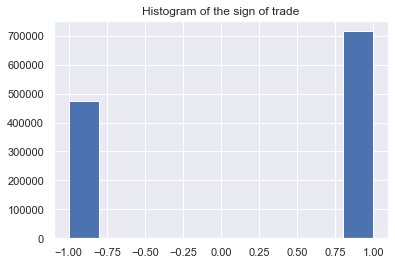

In [11]:
plt.hist(bbo_trade["trade_sign_eps"])
plt.title("Histogram of the sign of trade")
plt.show()

In [12]:
temp=pd.DataFrame()
temp[["eps","ask_price","bid_price","mid_price"]]=bbo_trade[["trade_sign_eps","ask_price","bid_price","mid_price"]]
temp.dropna(inplace=True)

In [13]:
temp.head()

,eps,ask_price,bid_price,mid_price
xltime,,,,
2010-05-06 09:30:00.215999744-04:00,1.0,116.27,116.25,116.26
2010-05-06 09:30:00.215999744-04:00,1.0,116.27,116.25,116.26
2010-05-06 09:30:00.215999744-04:00,1.0,116.27,116.25,116.26
2010-05-06 09:30:00.215999744-04:00,1.0,116.27,116.25,116.26
2010-05-06 09:30:00.215999744-04:00,1.0,116.27,116.25,116.26


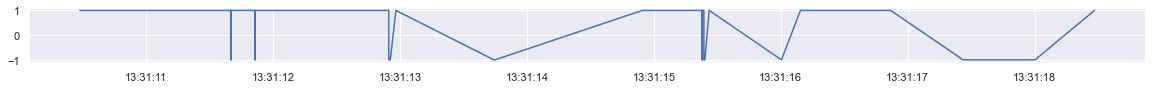

In [14]:
i=10000
plt.figure(figsize=(20,1))
plt.plot(temp["eps"].iloc[i:i+1000],'b')
plt.show()

In [21]:
def response_function(df,l):
    if(l<len(df.index)):
        return ((df["mid_price"].shift(1)-df["mid_price"].shift(l+1))*df["eps"].shift(l+1)).mean(axis=0)
    else:
        return None

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.33it/s]


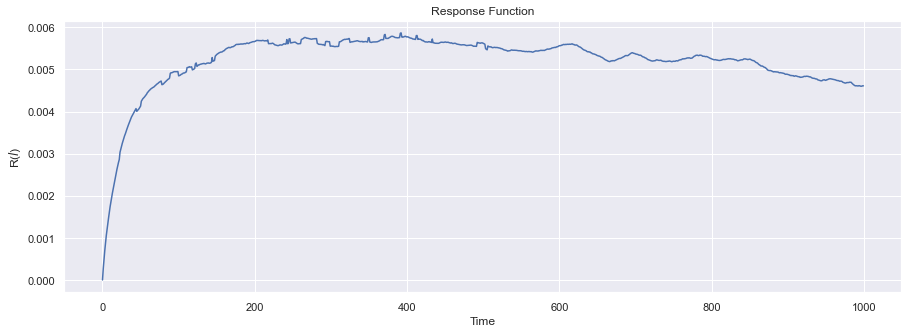

In [28]:
res=[]
for l in tqdm(range(1000)):
    res.append(response_function(temp,l))

plt.figure(figsize=(15,5))
plt.plot(res)
plt.title("Response Function")
plt.xlabel("Time")
plt.ylabel("R($l$)")
plt.show()

In [29]:
def fluctuation_function(df,l):
    if(l<len(df.index)):
        return ((df["mid_price"].shift(1)-df["mid_price"].shift(l+1))**2).mean(axis=0)
    else:
        return None

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]<ipython-input-30-22a37991d72f>:3: RuntimeWarning: invalid value encountered in double_scalars
  diffusian.append(fluctuation_function(temp,l)/l)
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.88it/s]


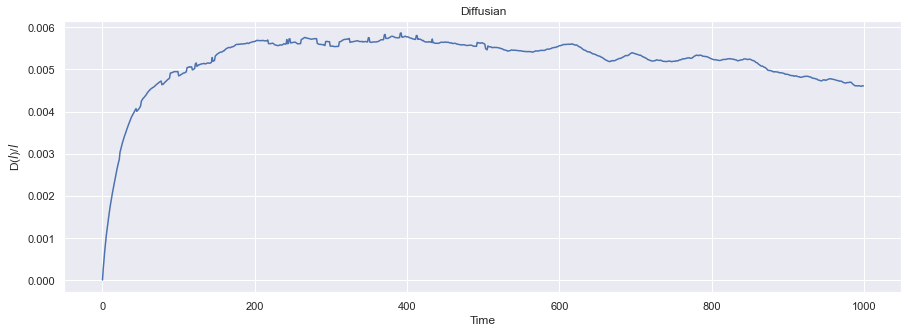

In [30]:
diffusian=[]
for l in tqdm(range(1000)):
    diffusian.append(fluctuation_function(temp,l)/l)

plt.figure(figsize=(15,5))
plt.plot(res)
plt.title("Diffusian")
plt.xlabel("Time")
plt.ylabel("D($l$)/$l$")
plt.show()